In [1]:
#import sys
import random
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
from keras import backend as K
from scipy import stats
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import regularizers
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from keras.utils import to_categorical
#!{sys.executable} -m pip install keras

Using TensorFlow backend.
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

# Preprocessing

In [2]:
"""
    Based on the training data given, we are able to extract 7 attributes:
    1. x accelerometer measurement
    2. y accelerometer measurement
    3. z accelerometer measurement
    4. x gyroscope measurement
    5. y gyroscope measurement
    6. z gyroscope measurement
    7. time stamp for accelerometer and gyroscope measures
    
    We start by creating a dataframe using the csv files provided for readability.
    
    @param x_file: contains the xyz accelerometers and xyz gyroscope measures from the lower limb
    @param x_time_file: contain the time stamps for the accelerometer and gyroscope measures
    @return dataframe of 7 attributes mentioned
"""
def create_dataframe_X(x_file, x_time_file):
    df1 = pd.read_csv(x_file, sep = ',', names = ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])
    df1 = scale_data(df1, ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])
    df2 = pd.read_csv(x_time_file, names = ['Time stamp'])
    frames = [df1, df2]
    result = pd.concat(frames, axis = 1)
    return result

"""
    Scale the values of X to make it robust to outliers.
    
    @param df: input dataframe
    @param columns: columns to scale
    @return scaled dataframe
"""
def scale_data(df, columns):
    scaler = RobustScaler()
    scaler = scaler.fit(df[columns])
    df.loc[:, columns] = scaler.transform(df[columns])
    return df
    
"""
    We have both the labels and the time stamps for the labels. We create a dataframe from these for
    readability.
    
    @param y_file: contain the labels: 
        (0) indicates standing or walking in solid ground, 
        (1) indicates going down the stairs, 
        (2) indicates going up the stairs, and 
        (3) indicates walking on grass
    @param y_time_file: contain the time stamps for the labels
    @return dataframe of labels and time stamps
""" 
def create_dataframe_Y(y_file, y_time_file):
    df1 = pd.read_csv(y_file, names = ['Label'])
    df2 = pd.read_csv(y_time_file, names = ['Time stamp'])
    frames = [df1, df2]
    result = pd.concat(frames, axis = 1)
    return result
    
"""
    We take the outputs of create_dataframe_X and create_dataframe_Y. In order to combine both of these
    dataframes, we need look at the time intervals present for when the labels were assigned. We down-sample
    the X to the shape of the y.
    
    @param x_frame: dataframe from create_dataframe_X
    @param y_frame: dataframe from create_dataframe_Y
    @return dataframe with 9 columns (8 attributes and 1 label)
"""
def combine_frames(x_frame, y_frame):
    # Change each dataframe column to a list for iterations
    time_stamp_y = y_frame['Time stamp'].tolist()
    time_stamp_x = x_frame['Time stamp'].tolist()
    
    x_range = [] # Empty list to append data points to
    x_random_row = 0 # Initializing variable to hold randomly selected row instance
    refs = []
    count = 0
    for i in range(0, len(time_stamp_y)):
        while (time_stamp_x[count] <= time_stamp_y[i]) and (count <= len(time_stamp_x)):
            x_range.append(time_stamp_x.index(time_stamp_x[count]))
            count += 1
        x_random_row = random.choice(x_range) # Pick a random value
        refs.append(x_random_row) # Keep record of selected rows
        x_range.clear() # Clear the cache
        continue
    
    # Create a new dataframe based on the refs collected - should be roughly the same length as the y_frame
    entries = []
    for item in refs:
        entry = x_frame.iloc[item]
        entries.append(entry)
    
    found_df = pd.concat(entries, axis = 1)
    found_df = found_df.transpose()
    
    # Combine found_df with y_frame for downsampling
    found_df = found_df.reset_index()
    found_df = found_df.drop(['index'], axis = 1)
    found_df = found_df.drop(['Time stamp'], axis = 1)
    combined_frame = pd.concat([found_df, y_frame], axis = 1)
    return combined_frame

"""
    Takes in the sequential X and y and creates windows of time-series data.
    
    @param X: input data
    @param y: label data
    @param time_steps: determines size of window
    @param step: incremental value that window will slide over
    @return time series of X and y data
"""
def mode_labels(X, y, time_steps, step):
    X_values = []
    y_values = []
    for i in range(0, len(X) - time_steps, step):
        value = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: (i + time_steps)]
        X_values.append(value)
        y_values.append(stats.mode(labels)[0][0])
    return np.array(X_values), np.array(y_values).reshape(-1, 1)

"""
    Generating data frames from training data.
    
    @param X_file: list of input X files
    @param X_t_file: list of input X_time files
    @param y_file: list of input y files
    @param y_t file: list of y_time files
    @return stacked window of instances across all training files, stack window of labels across all label files
"""
def generate_data(X_file, X_t_file, y_file, y_t_file):
    all_X = []
    all_y = []
    for item_X, item_X_t, item_y, item_y_t in zip(X_file, X_t_file, y_file, y_t_file):
        df_x = create_dataframe_X(item_X, item_X_t)
        df_y = create_dataframe_Y(item_y, item_y_t)
        combined_frame = combine_frames(df_x, df_y)
        X_temp = combined_frame[['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr']]
        y_temp = combined_frame['Label']
        X, y = mode_labels(X_temp, y_temp, 30, 1)
        all_X.append(X)
        all_y.append(y)
    return np.concatenate(all_X), np.concatenate(all_y)

In [3]:
# List of training X_files
X_files = ['TrainingData/subject_001_01__x.csv', 'TrainingData/subject_001_02__x.csv', 
           'TrainingData/subject_001_03__x.csv', 'TrainingData/subject_001_04__x.csv',
           'TrainingData/subject_001_05__x.csv', 'TrainingData/subject_001_06__x.csv',
           'TrainingData/subject_001_07__x.csv', 'TrainingData/subject_001_08__x.csv',
           'TrainingData/subject_002_01__x.csv', 'TrainingData/subject_002_02__x.csv',
           'TrainingData/subject_002_03__x.csv', 'TrainingData/subject_001_04__x.csv',
           'TrainingData/subject_002_05__x.csv', 'TrainingData/subject_003_01__x.csv',
           'TrainingData/subject_005_01__x.csv', 'TrainingData/subject_005_02__x.csv',
           'TrainingData/subject_005_03__x.csv', 'TrainingData/subject_006_01__x.csv',
           'TrainingData/subject_006_02__x.csv', 'TrainingData/subject_006_03__x.csv',
           'TrainingData/subject_007_01__x.csv', 'TrainingData/subject_007_02__x.csv',
           'TrainingData/subject_007_03__x.csv', 'TrainingData/subject_007_04__x.csv',
           'TrainingData/subject_008_01__x.csv']

# List of training X_t_files
X_t_files = ['TrainingData/subject_001_01__x_time.csv', 'TrainingData/subject_001_02__x_time.csv', 
             'TrainingData/subject_001_03__x_time.csv', 'TrainingData/subject_001_04__x_time.csv',
             'TrainingData/subject_001_05__x_time.csv', 'TrainingData/subject_001_06__x_time.csv',
             'TrainingData/subject_001_07__x_time.csv', 'TrainingData/subject_001_08__x_time.csv',
             'TrainingData/subject_002_01__x_time.csv', 'TrainingData/subject_002_02__x_time.csv',
             'TrainingData/subject_002_03__x_time.csv', 'TrainingData/subject_001_04__x_time.csv',
             'TrainingData/subject_002_05__x_time.csv', 'TrainingData/subject_003_01__x_time.csv',
             'TrainingData/subject_005_01__x_time.csv', 'TrainingData/subject_005_02__x_time.csv',
             'TrainingData/subject_005_03__x_time.csv', 'TrainingData/subject_006_01__x_time.csv',
             'TrainingData/subject_006_02__x_time.csv', 'TrainingData/subject_006_03__x_time.csv',
             'TrainingData/subject_007_01__x_time.csv', 'TrainingData/subject_007_02__x_time.csv',
             'TrainingData/subject_007_03__x_time.csv', 'TrainingData/subject_007_04__x_time.csv',
             'TrainingData/subject_008_01__x_time.csv']

# List of training y_files
y_files = ['TrainingData/subject_001_01__y.csv', 'TrainingData/subject_001_02__y.csv', 
           'TrainingData/subject_001_03__y.csv', 'TrainingData/subject_001_04__y.csv',
           'TrainingData/subject_001_05__y.csv', 'TrainingData/subject_001_06__y.csv',
           'TrainingData/subject_001_07__y.csv', 'TrainingData/subject_001_08__y.csv',
           'TrainingData/subject_002_01__y.csv', 'TrainingData/subject_002_02__y.csv',
           'TrainingData/subject_002_03__y.csv', 'TrainingData/subject_001_04__y.csv',
           'TrainingData/subject_002_05__y.csv', 'TrainingData/subject_003_01__y.csv',
           'TrainingData/subject_005_01__y.csv', 'TrainingData/subject_005_02__y.csv',
           'TrainingData/subject_005_03__y.csv', 'TrainingData/subject_006_01__y.csv',
           'TrainingData/subject_006_02__y.csv', 'TrainingData/subject_006_03__y.csv',
           'TrainingData/subject_007_01__y.csv', 'TrainingData/subject_007_02__y.csv',
           'TrainingData/subject_007_03__y.csv', 'TrainingData/subject_007_04__y.csv',
           'TrainingData/subject_008_01__y.csv']

# List of training y_t_files
y_t_files = ['TrainingData/subject_001_01__y_time.csv', 'TrainingData/subject_001_02__y_time.csv', 
             'TrainingData/subject_001_03__y_time.csv', 'TrainingData/subject_001_04__y_time.csv',
             'TrainingData/subject_001_05__y_time.csv', 'TrainingData/subject_001_06__y_time.csv',
             'TrainingData/subject_001_07__y_time.csv', 'TrainingData/subject_001_08__y_time.csv',
             'TrainingData/subject_002_01__y_time.csv', 'TrainingData/subject_002_02__y_time.csv',
             'TrainingData/subject_002_03__y_time.csv', 'TrainingData/subject_001_04__y_time.csv',
             'TrainingData/subject_002_05__y_time.csv', 'TrainingData/subject_003_01__y_time.csv',
             'TrainingData/subject_005_01__y_time.csv', 'TrainingData/subject_005_02__y_time.csv',
             'TrainingData/subject_005_03__y_time.csv', 'TrainingData/subject_006_01__y_time.csv',
             'TrainingData/subject_006_02__y_time.csv', 'TrainingData/subject_006_03__y_time.csv',
             'TrainingData/subject_007_01__y_time.csv', 'TrainingData/subject_007_02__y_time.csv',
             'TrainingData/subject_007_03__y_time.csv', 'TrainingData/subject_007_04__y_time.csv',
             'TrainingData/subject_008_01__y_time.csv']

# Use some files to create validation set
val_X = ['TrainingData/subject_003_02__x.csv', 'TrainingData/subject_003_03__x.csv',
         'TrainingData/subject_004_01__x.csv', 'TrainingData/subject_004_02__x.csv',]
val_X_t = ['TrainingData/subject_003_02__x_time.csv', 'TrainingData/subject_003_03__x_time.csv',
           'TrainingData/subject_004_01__x_time.csv', 'TrainingData/subject_004_02__x_time.csv',]
val_y = ['TrainingData/subject_003_02__y.csv', 'TrainingData/subject_003_03__y.csv',
         'TrainingData/subject_004_01__y.csv', 'TrainingData/subject_004_02__y.csv',]
val_y_t = ['TrainingData/subject_003_02__y_time.csv', 'TrainingData/subject_003_03__y_time.csv',
           'TrainingData/subject_004_01__y_time.csv', 'TrainingData/subject_004_02__y_time.csv',]

training_X, training_y = generate_data(X_files, X_t_files, y_files, y_t_files)
val_X, val_y = generate_data(val_X, val_X_t, val_y, val_y_t)
print(training_X.shape, training_y.shape)
print(val_X.shape, val_y.shape)

(301655, 30, 6) (301655, 1)
(33762, 30, 6) (33762, 1)


In [4]:
label_weights = class_weight.compute_class_weight('balanced', np.unique(training_y), training_y.ravel())
print(label_weights)
label_weights = {i:label_weights[i] for i in range(len(label_weights))} # Create dictionary
print(label_weights)

[0.33593218 5.81133929 4.44263623 1.59734284]
{0: 0.3359321754546953, 1: 5.811339292594591, 2: 4.442636229749632, 3: 1.5973428365669744}


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [5]:
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
encoder = encoder.fit(training_y)
training_y_encoded = encoder.transform(training_y)
val_y_encoded = encoder.transform(val_y)

In [6]:
def recall_measure(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_measure(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_measure(y_true, y_pred)
    recall = recall_measure(y_true, y_pred)
    return 2 * ((precision * recall)/(precision + recall + K.epsilon()))

In [42]:
n_timesteps, n_features, n_outputs = training_X.shape[1], training_X.shape[2], training_y_encoded.shape[1]

def define_LSTM_model(dropout_rate, l1_value, l2_value):
    model = Sequential()
    model.add(LSTM(units = 125, kernel_regularizer = regularizers.l1_l2(l1=l1_value, l2=l2_value),
                   input_shape = (n_timesteps, n_features)))
    model.add(Dropout(rate = dropout_rate))
    model.add(Dense(units = 125, activation = 'relu'))
    model.add(Dense(units = n_outputs, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                  metrics = ['accuracy', f1, precision_measure, recall_measure])
    return model
    
def evaluate_model(training_X, training_y_encoded, val_X, val_y_encoded, dropout_rate, l1_value, l2_value):
    verbose, epochs, batch_size = 1, 30, 64
    model = define_LSTM_model(dropout_rate, l1_value, l2_value)
    model.summary()
    # Fit network
    history = model.fit(training_X, training_y_encoded, epochs = epochs, batch_size = batch_size, 
              validation_data = (val_X, val_y_encoded), class_weight = label_weights, verbose = verbose)
    # Evaluate model
    loss, accuracy, f1, precision, recall = model.evaluate(val_X, val_y_encoded, batch_size = batch_size, verbose = verbose)
    return model, history, accuracy, f1, precision, recall

# Defining a function for plotting training and validation learning curves
def plot_history(history):
	# Plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # Plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['acc'], color='blue', label='train')
    plt.plot(history.history['val_acc'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # Plot F1
    plt.title('F1-Score')
    plt.plot(history.history['f1'], color='blue', label='train')
    plt.plot(history.history['val_f1'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # Plot precision
    plt.title('Precision')
    plt.plot(history.history['precision_measure'], color='blue', label='train')
    plt.plot(history.history['val_precision_measure'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # Plot recall
    plt.title('Recall')
    plt.plot(history.history['recall_measure'], color='blue', label='train')
    plt.plot(history.history['val_recall_measure'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [29]:
# Define the dropout grid
dropout_grid = [0.1, 0.5, 0.9]
l1_grid = [2**-5, 2**-6, 2**-7, 2**-8]
l2_grid = [2**-5, 2**-6, 2**-7, 2**-8]
tot = len(dropout_grid) * len(l1_grid) * len(l2_grid)

# Variables for the best result
scores = []
best_history = [] # place holder
best_ind = 0
best_acc = 0

# Loop through each combination
pos = 0
for ii in dropout_grid:
    for jj in l1_grid:
        for kk in l2_grid:
            pos = pos + 1
            print("Fitting ", pos, "/", tot , " model")
            # define the model
            curr_model = define_LSTM_model(ii, jj, kk)
            #curr_model.summary()
            
            # train the model
            curr_history = curr_model.fit(training_X, training_y_encoded, epochs = 8, batch_size = 64, 
                                     validation_data = (val_X, val_y_encoded), class_weight = label_weights, 
                                     verbose = 1)
            curr_acc = st.mean(curr_history.history['val_acc'][5:10])
                        
            # get prediction report
            y_pred = curr_model.predict(val_X, batch_size=64, verbose=1)
            y_pred_bool = np.argmax(y_pred, axis=1)
            scores.append(classification_report(val_y, y_pred_bool))
            
            # save the best result
            if best_acc < curr_acc:
                best_acc = curr_acc
                best_ind = pos - 1
                best_history = curr_history

# Display best best_ind, best_acc, and best_history
print(best_ind)
print(best_acc)
print(best_history)

Fitting  1 / 48  model
Train on 301655 samples, validate on 33762 samples
Epoch 1/8
301655/301655 [==============================] - 310s 1ms/step - loss: 0.7947 - acc: 0.5508 - f1: 0.4722 - precision_measure: 0.5823 - recall_measure: 0.4294 - val_loss: 0.8487 - val_acc: 0.5053 - val_f1: 0.4855 - val_precision_measure: 0.5074 - val_recall_measure: 0.4686
Epoch 2/8
301655/301655 [==============================] - 205s 680us/step - loss: 0.4590 - acc: 0.7079 - f1: 0.7024 - precision_measure: 0.7151 - recall_measure: 0.6903 - val_loss: 0.9917 - val_acc: 0.5042 - val_f1: 0.4989 - val_precision_measure: 0.5046 - val_recall_measure: 0.4938
Epoch 3/8
301655/301655 [==============================] - 203s 674us/step - loss: 0.3812 - acc: 0.7785 - f1: 0.7764 - precision_measure: 0.7840 - recall_measure: 0.7692 - val_loss: 0.7051 - val_acc: 0.7158 - val_f1: 0.7134 - val_precision_measure: 0.7201 - val_recall_measure: 0.7073
Epoch 4/8
301655/301655 [==============================] - 187s 620us/ste

301655/301655 [==============================] - 204s 677us/step - loss: 0.2204 - acc: 0.8794 - f1: 0.8793 - precision_measure: 0.8805 - recall_measure: 0.8780 - val_loss: 0.6791 - val_acc: 0.7359 - val_f1: 0.7352 - val_precision_measure: 0.7368 - val_recall_measure: 0.7337
Epoch 8/8
33762/33762 [==============================] - 8s 243us/step
Fitting  8 / 48  model
Train on 301655 samples, validate on 33762 samples
Epoch 1/8
301655/301655 [==============================] - 193s 641us/step - loss: 0.6156 - acc: 0.6066 - f1: 0.5579 - precision_measure: 0.6166 - recall_measure: 0.5311 - val_loss: 0.6634 - val_acc: 0.6733 - val_f1: 0.6656 - val_precision_measure: 0.6779 - val_recall_measure: 0.6552
Epoch 2/8
301655/301655 [==============================] - 194s 643us/step - loss: 0.3720 - acc: 0.7790 - f1: 0.7768 - precision_measure: 0.7852 - recall_measure: 0.7687 - val_loss: 0.4802 - val_acc: 0.8307 - val_f1: 0.8282 - val_precision_measure: 0.8333 - val_recall_measure: 0.8234
Epoch 3/8


Epoch 2/8
301655/301655 [==============================] - 194s 644us/step - loss: 0.3569 - acc: 0.8004 - f1: 0.7987 - precision_measure: 0.8072 - recall_measure: 0.7905 - val_loss: 0.7583 - val_acc: 0.6407 - val_f1: 0.6378 - val_precision_measure: 0.6426 - val_recall_measure: 0.6334
Epoch 3/8
301655/301655 [==============================] - 188s 622us/step - loss: 0.3059 - acc: 0.8308 - f1: 0.8302 - precision_measure: 0.8357 - recall_measure: 0.8249 - val_loss: 0.5916 - val_acc: 0.7559 - val_f1: 0.7519 - val_precision_measure: 0.7592 - val_recall_measure: 0.7454
Epoch 4/8
301655/301655 [==============================] - 189s 627us/step - loss: 0.2744 - acc: 0.8487 - f1: 0.8483 - precision_measure: 0.8521 - recall_measure: 0.8446 - val_loss: 0.5372 - val_acc: 0.7806 - val_f1: 0.7791 - val_precision_measure: 0.7840 - val_recall_measure: 0.7746
Epoch 5/8
301655/301655 [==============================] - 186s 617us/step - loss: 0.2481 - acc: 0.8639 - f1: 0.8637 - precision_measure: 0.8662 

33762/33762 [==============================] - 7s 193us/step
Fitting  18 / 48  model
Train on 301655 samples, validate on 33762 samples
Epoch 1/8
301655/301655 [==============================] - 187s 621us/step - loss: 0.7903 - acc: 0.5577 - f1: 0.4745 - precision_measure: 0.5876 - recall_measure: 0.4338 - val_loss: 1.0269 - val_acc: 0.4622 - val_f1: 0.4279 - val_precision_measure: 0.4649 - val_recall_measure: 0.4027
Epoch 2/8
301655/301655 [==============================] - 181s 601us/step - loss: 0.4708 - acc: 0.6968 - f1: 0.6898 - precision_measure: 0.7038 - recall_measure: 0.6766 - val_loss: 0.9185 - val_acc: 0.5635 - val_f1: 0.5574 - val_precision_measure: 0.5637 - val_recall_measure: 0.5517
Epoch 3/8
301655/301655 [==============================] - 184s 609us/step - loss: 0.4047 - acc: 0.7644 - f1: 0.7620 - precision_measure: 0.7704 - recall_measure: 0.7540 - val_loss: 0.8262 - val_acc: 0.5416 - val_f1: 0.5353 - val_precision_measure: 0.5428 - val_recall_measure: 0.5288
Epoch 4/8

Epoch 3/8
301655/301655 [==============================] - 177s 587us/step - loss: 0.3653 - acc: 0.7888 - f1: 0.7870 - precision_measure: 0.7952 - recall_measure: 0.7792 - val_loss: 0.5355 - val_acc: 0.7941 - val_f1: 0.7924 - val_precision_measure: 0.7961 - val_recall_measure: 0.7891
Epoch 4/8
301655/301655 [==============================] - 179s 595us/step - loss: 0.3287 - acc: 0.8149 - f1: 0.8139 - precision_measure: 0.8200 - recall_measure: 0.8079 - val_loss: 0.4719 - val_acc: 0.7974 - val_f1: 0.7960 - val_precision_measure: 0.7989 - val_recall_measure: 0.7934
Epoch 5/8
301655/301655 [==============================] - 178s 589us/step - loss: 0.3038 - acc: 0.8307 - f1: 0.8300 - precision_measure: 0.8349 - recall_measure: 0.8252 - val_loss: 0.5042 - val_acc: 0.8066 - val_f1: 0.8058 - val_precision_measure: 0.8085 - val_recall_measure: 0.8032
Epoch 6/8
301655/301655 [==============================] - 179s 594us/step - loss: 0.2834 - acc: 0.8428 - f1: 0.8424 - precision_measure: 0.8463 

301655/301655 [==============================] - 181s 601us/step - loss: 0.5797 - acc: 0.6095 - f1: 0.5784 - precision_measure: 0.6261 - recall_measure: 0.5517 - val_loss: 0.8433 - val_acc: 0.5708 - val_f1: 0.5503 - val_precision_measure: 0.5727 - val_recall_measure: 0.5326
Epoch 2/8
301655/301655 [==============================] - 182s 603us/step - loss: 0.3772 - acc: 0.7672 - f1: 0.7641 - precision_measure: 0.7733 - recall_measure: 0.7552 - val_loss: 0.8040 - val_acc: 0.6046 - val_f1: 0.6029 - val_precision_measure: 0.6064 - val_recall_measure: 0.5997
Epoch 3/8
301655/301655 [==============================] - 179s 592us/step - loss: 0.3234 - acc: 0.8167 - f1: 0.8157 - precision_measure: 0.8210 - recall_measure: 0.8104 - val_loss: 0.4420 - val_acc: 0.8572 - val_f1: 0.8560 - val_precision_measure: 0.8602 - val_recall_measure: 0.8523
Epoch 4/8
301655/301655 [==============================] - 179s 593us/step - loss: 0.2867 - acc: 0.8402 - f1: 0.8395 - precision_measure: 0.8434 - recall_m

301655/301655 [==============================] - 195s 647us/step - loss: 0.4646 - acc: 0.6795 - f1: 0.6726 - precision_measure: 0.6863 - recall_measure: 0.6598 - val_loss: 0.8543 - val_acc: 0.4523 - val_f1: 0.4455 - val_precision_measure: 0.4531 - val_recall_measure: 0.4390
Epoch 8/8
33762/33762 [==============================] - 10s 303us/step
Fitting  35 / 48  model
Train on 301655 samples, validate on 33762 samples
Epoch 1/8
301655/301655 [==============================] - 236s 784us/step - loss: 0.9664 - acc: 0.4667 - f1: 0.3206 - precision_measure: 0.5116 - recall_measure: 0.2666 - val_loss: 0.8225 - val_acc: 0.3130 - val_f1: 0.2689 - val_precision_measure: 0.3215 - val_recall_measure: 0.2482
Epoch 2/8
301655/301655 [==============================] - 198s 656us/step - loss: 0.5963 - acc: 0.4664 - f1: 0.4308 - precision_measure: 0.4648 - recall_measure: 0.4027 - val_loss: 0.7680 - val_acc: 0.4685 - val_f1: 0.4581 - val_precision_measure: 0.4695 - val_recall_measure: 0.4484
Epoch 3/

301655/301655 [==============================] - 273s 906us/step - loss: 0.4753 - acc: 0.6369 - f1: 0.6214 - precision_measure: 0.6409 - recall_measure: 0.6036 - val_loss: 0.7970 - val_acc: 0.5633 - val_f1: 0.5493 - val_precision_measure: 0.5611 - val_recall_measure: 0.5397
Epoch 5/8
301655/301655 [==============================] - 223s 741us/step - loss: 0.4388 - acc: 0.6903 - f1: 0.6828 - precision_measure: 0.6966 - recall_measure: 0.6698 - val_loss: 0.7217 - val_acc: 0.5997 - val_f1: 0.5930 - val_precision_measure: 0.5992 - val_recall_measure: 0.5877
Epoch 6/8
301655/301655 [==============================] - 238s 789us/step - loss: 0.4161 - acc: 0.7208 - f1: 0.7160 - precision_measure: 0.7275 - recall_measure: 0.7050 - val_loss: 0.7697 - val_acc: 0.5393 - val_f1: 0.5305 - val_precision_measure: 0.5384 - val_recall_measure: 0.5237
Epoch 7/8
301655/301655 [==============================] - 193s 641us/step - loss: 0.4013 - acc: 0.7342 - f1: 0.7285 - precision_measure: 0.7398 - recall_m

301655/301655 [==============================] - 302s 1ms/step - loss: 0.6530 - acc: 0.5406 - f1: 0.4850 - precision_measure: 0.5525 - recall_measure: 0.4463 - val_loss: 0.7665 - val_acc: 0.6180 - val_f1: 0.5966 - val_precision_measure: 0.6188 - val_recall_measure: 0.5787
Epoch 2/8
301655/301655 [==============================] - 275s 911us/step - loss: 0.4464 - acc: 0.7241 - f1: 0.7151 - precision_measure: 0.7324 - recall_measure: 0.6991 - val_loss: 0.5692 - val_acc: 0.7431 - val_f1: 0.7377 - val_precision_measure: 0.7444 - val_recall_measure: 0.7315
Epoch 3/8
301655/301655 [==============================] - 280s 929us/step - loss: 0.3809 - acc: 0.7920 - f1: 0.7889 - precision_measure: 0.7993 - recall_measure: 0.7789 - val_loss: 0.5787 - val_acc: 0.7232 - val_f1: 0.7181 - val_precision_measure: 0.7235 - val_recall_measure: 0.7132
Epoch 4/8
301655/301655 [==============================] - 307s 1ms/step - loss: 0.3489 - acc: 0.8112 - f1: 0.8095 - precision_measure: 0.8178 - recall_measu

The above hyperparamter search for this LSTM returns that index 7 is the best index combination of hyperparameters, returning an accuracy of 0.8655490393539087. The hyperparamters that correspond to this index are found in 'Fitting Model 8 / 48' (results are in log file). They are `dropout_rate` = 0.1, `l1` = 2e-6, `l2` = 2e-8.

In [ ]:
# Optimal parameters: dropout_rate = 0.1, l1 = 2e-6, l2 = 2e-8
best_model, best_history, best_accuracy, best_f1, best_precision, best_recall = evaluate_model(training_X, 
                                                                                   training_y_encoded, 
                                                                                   val_X, val_y_encoded, 
                                                                                   0.1, 2**-6, 2**-8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 125)               66000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 125)               15750     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 504       
Total params: 82,254
Trainable params: 82,254
Non-trainable params: 0
_________________________________________________________________
Train on 301655 samples, validate on 33762 samples
Epoch 1/30
301655/301655 [==============================] - 397s 1ms/step - loss: 0.6167 - acc: 0.5919 - f1: 0.5563 - precision_measure: 0.6098 - recall_measure: 0.5277 - val_loss: 0.9235 - val_acc: 0.4953 - val_f1: 0.4

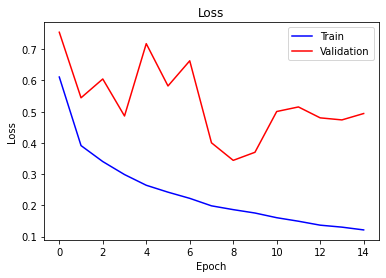

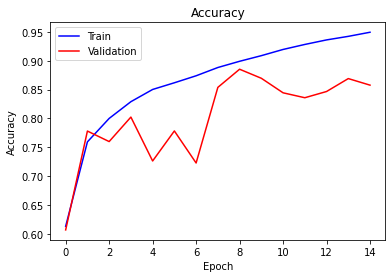

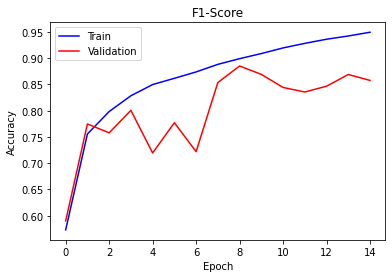

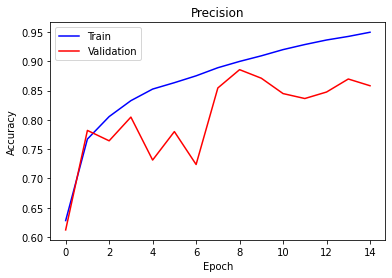

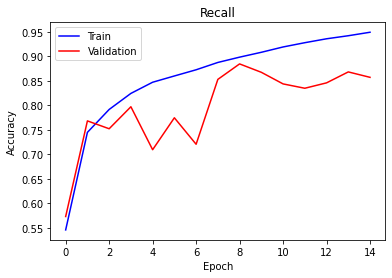

In [10]:
plot_history(best_history)

In [11]:
curr_acc = st.mean(best_history.history['val_acc'][10:15])
print(curr_acc)

0.8508263728452106


In [12]:
# Get prediction report
y_pred = best_model.predict(val_X, batch_size = 64, verbose = 1)
y_pred_bool = np.argmax(y_pred, axis = 1)
print(classification_report(val_y, y_pred_bool))

33762/33762 [==============================] - 8s 247us/step
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     26856
           1       0.80      1.00      0.89      1446
           2       0.87      1.00      0.93      1602
           3       0.48      0.89      0.62      3858

    accuracy                           0.86     33762
   macro avg       0.78      0.93      0.83     33762
weighted avg       0.91      0.86      0.87     33762



In [56]:
validation = pd.DataFrame({'Y':val_y.flatten(), 'Prediction':y_pred_bool})
validation = pd.DataFrame(list(zip(val_y.flatten(), y_pred_bool)), columns = ['Y', 'Prediction'])
validation.to_csv('validation_prediction.csv')

In [41]:
# Get predictions using test data
test_files = ['TestData/subject_009_01__x.csv', 'TestData/subject_010_01__x.csv', 
             'TestData/subject_011_01__x.csv', 'TestData/subject_012_01__x.csv']

y_files = ['TestData/subject_009_01__y_time.csv', 'TestData/subject_010_01__y_time.csv',
          'TestData/subject_011_01__y_time.csv', 'TestData/subject_012_01__y_time.csv']

prediction_files = ['subject_009_01__y_prediction.csv', 'subject_010_01__y_prediction.csv',
                   'subject_011_01__y_prediction.csv', 'subject_012_01__y_prediction.csv']

def generate_test_data(X, time_steps, step):
    X_values = []
    for i in range(0, len(X) - time_steps, step):
        value = X.iloc[i:(i + time_steps)].values
        X_values.append(value)
    return np.array(X_values)

def reduce(y):
    y_output = []
    for i in range(0, y.shape[0], 4):
        item = list(y[i:i + 4])
        y_output.append(max(item, key = item.count))
    return np.array(y_output)

for i in range(len(test_files)):
    test_input = pd.read_csv(test_files[i])
    test_input = scale_data(test_input, list(test_input.columns.values))
    y_frame = pd.read_csv(y_files[i])
    print(y_frame.shape)

    add_to_frame = y_frame.shape[0] * 4 - test_input.shape[0] + 30
    adding_dataframe = pd.DataFrame(test_input.iloc[-add_to_frame:])
    test_input = test_input.append(adding_dataframe)
    
    # Apply window technique
    X_test = generate_test_data(test_input, 30, 1)

    y_hat_encoded = best_model.predict(X_test, batch_size = 64, verbose = 1)
    
    y_hat = np.argmax(y_hat_encoded, axis = 1)
    
    y_actual = reduce(y_hat)
    #y_actual = y_actual[np.arange(y_actual.size - 1)]
    
    print(y_actual.shape)
    
    y_series = pd.Series(y_actual)
    y_series.to_csv("C2_predictions/" + prediction_files[i])

(9497, 1)
37988/37988 [==============================] - 7s 177us/step
(9497,)
(12269, 1)
49076/49076 [==============================] - 9s 184us/step
(12269,)
(12939, 1)
51756/51756 [==============================] - 10s 188us/step
(12939,)
(11329, 1)
45316/45316 [==============================] - 9s 194us/step
(11329,)


In [37]:
x = pd.read_csv('TestData/subject_009_01__y_time.csv')
print(len(x))

9497


In [38]:
x = pd.read_csv('TestData/subject_010_01__y_time.csv')
print(len(x))

12269


In [39]:
x = pd.read_csv('TestData/subject_011_01__y_time.csv')
print(len(x))

12939


In [40]:
x = pd.read_csv('TestData/subject_012_01__y_time.csv')
print(len(x))

11329
